# 1. Specify the system type

In [1]:
import warnings
warnings.filterwarnings("ignore")

# specify the system
from RBG_Maxwell.Collision_database.select_system import which_system

plasma_system = 'Fusion_system'
which_system(plasma_system)

from RBG_Maxwell.Collision_database.Fusion_system.collision_type import collision_type_for_all_species
import ray
ray.shutdown()
ray.init(_temp_dir='/data/smy')

2024-05-21 17:30:52,000	INFO worker.py:1622 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8270 


Python version:,3.7.13
Ray version:,2.4.0
Dashboard:,http://127.0.0.1:8270


# 2. Specify the coefficient for unit conversion 

In [2]:
from RBG_Maxwell.Unit_conversion.main import determine_coefficient_for_unit_conversion, unit_conversion
import numpy as np

In [3]:
# here we use a pure electron system
# the relavant PIC code is given by Jian-Nan Chen

# give the quantities in SI
# the spatial grid is chosen to be dx=dy=dz=10**(-4) m
dx = dy = 10**(-5)
dz = 10**(-5)

# velocity
v = 0
v_max = 1.5*10**6

# charge
Q = 1.6*10**(-19) 

# maximum momentum is roughly 10**(-30)kg*10**5m/s
momentum = 10**(-30)*v_max

# the momentum grid is set to be 
# npy=100, npx=npz=1, half_px=half_pz=half_py~10**(-25)
dp = momentum/100
dp_volume = momentum**3/100

# time scale
dt = 10**(-13)

n_max = 5*10**(-14)/(1.6*10**(-19))/101
n_average = 5*10**(-14)/(1.6*10**(-19))/101/251


E = 10**8
B = 10

# Now find the coefficient
hbar, c, lambdax, epsilon0 = determine_coefficient_for_unit_conversion(dt, dx, dx*dy*dz, dp, dp_volume,\
                                                                       n_max, n_average, v_max, E, B)

Searching for proper scaling parameters...
This may take several minutes.


In [4]:
hbar, c, lambdax, epsilon0

(1e-06, 1000000000, 1e-22, 1e-05)

In [5]:
conversion_table = \
unit_conversion('SI_to_LHQCD', coef_J_to_E=lambdax, hbar=hbar, c=c, k=1., epsilon0=epsilon0)
conversion_table_reverse = \
unit_conversion('LHQCD_to_SI', coef_J_to_E=lambdax, hbar=hbar, c=c, k=1., epsilon0=epsilon0)

# 3. Specify the configurations for plasma evolution

In [6]:
# import the main class Plasma
from RBG_Maxwell.Plasma.main import Plasma

In [7]:
# time step, and spatial infinitesimals
# dt is 10**(-13) s, dx = dy = dz = 10**(-5) m
dt, dx, dy, dz = dt*conversion_table['second'], \
                 dx*conversion_table['meter'], \
                 dy*conversion_table['meter'], \
                 dz*conversion_table['meter']

# we have only one type of particle e-
num_particle_species = 1

# treat the electron as classical particles
particle_type = np.array([0])

# masses, charges and degenericies are
masses, charges, degeneracy = np.array([9.11*10**(-31)*conversion_table['kilogram']]), \
                              np.array([-1.6*10**(-19)*conversion_table['Coulomb']]),\
                              np.array([1.])

# momentum grids
npx, npy, npz = 1, 201, 1

# half_px, half_py, half_pz
# momentum range for x and z direction are not import in this case
half_px, half_py, half_pz = np.array([9.11*10**(-31)*v_max*conversion_table['momentum']]), \
                            np.array([9.11*10**(-31)*v_max*conversion_table['momentum']]),\
                            np.array([9.11*10**(-31)*v_max*conversion_table['momentum']])

dpx, dpy, dpz = 2*half_px/npx, 2*half_py/npy, 2*half_pz/npz

# load the collision matrix
flavor, collision_type, particle_order = collision_type_for_all_species()
expected_collision_type = ['2TO2']

# 4. Specify the parallel configuration for plasma evolution

In [8]:
# number of spatial grids
# must be integers and lists
# odd numbers are recomended
# the maximum spatial gird is limited by CUDA, it's about nx*ny*nz~30000 for each card
nx_o, ny_o, nz_o = [1], [251], [111]

# value of the left boundary
# this is the 
x_left_bound_o, y_left_bound_o, z_left_bound_o = [-0.5*dx],\
                                                 [-125.5*dy],\
                                                 [-55.5*dz]

# number samples gives the number of sample points in MC integration
num_samples = 100

# Only specify one spatial region
number_regions = 1

# each spatial should use the full GPU, this number can be fractional if many regions are chosen
# and only one GPU is available
num_gpus_for_each_region = 1


# since only one region is specified, this will be empty
sub_region_relations = {'indicator': [[]],\
                        'position': [[]]}

# if np.ones are used, the boundaries are absorbing boundaries
# if np.zeros are used, it is reflection boundary
# numbers in between is also allowed
boundary_configuration = {}
for i_reg in range(number_regions):
    bound_x = np.ones([ny_o[i_reg], nz_o[i_reg]])
    bound_y = np.ones([nz_o[i_reg], nx_o[i_reg]])
    bound_z = np.ones([nx_o[i_reg], ny_o[i_reg]])
    boundary_configuration[i_reg] = (bound_x, bound_y, bound_z)

# 5. Specify the initial and boundary condition for plasma evolution

In [9]:
num_momentum_levels = 1

# iniital distribution function
f = {}
for i_reg in range(number_regions):
    f[i_reg] = np.zeros([num_momentum_levels, num_particle_species,\
                         nx_o[i_reg], ny_o[i_reg], nz_o[i_reg], npx, npy, npz])


In [10]:
'''
The total number of particles is 5*10**(-13)/(1.6*10**(-19)) ~ 31249999.999999996.
Put these particles in 101 grids, the number density of the particles is 
31249999.999999996/(101*dx*dy*dz) ~ 756837.0957070973 -> Delta_N/Delta_V.
The particles only possess the momentum region of size dpx*dpy*dpz,
hence the distribution function at each phase space grid is
756837.0957070973/(dpx*dpy*dpz) ~ 756837.0957070973/(2*half_px/npx*2*half_py/npy*2*half_pz/npz)
~ 1234.63197049
'''
dn_dv = 5*10**(-14)/(1.6*10**(-19))/(101*dx*dy*dz*dpx*dpy*dpz)

# nx=0, ny=90, nz=[30:41]
# e-, the first two indices correspond to num_momentum_levels=1, and num_particle_types=1
ai = 0
import math
for i in range(3,101):
    f[0][0, 0, 0,125,5:106,0,100+i,0] = math.exp(-(i/2.7986)**2)*dn_dv
    f[0][0, 0, 0,125,5:106,0,100-i,0] = math.exp(-(i/2.7986)**2)*dn_dv
    ai += 2*math.exp(-(i/2.7986)**2)
    
# f[0][0, 0, 0,125,5:106,0,101,0] = dn_dv/10**3
# f[0][0, 0, 0,125,5:106,0,99,0] = dn_dv/10**3
# f[0][0, 0, 0,125,5:106,0,100,0] = (1-ai)*dn_dv

# f[0][0, 0, 0,8,5:106,0,ipy,0] = 0.778801*dn_dv
# f[0][0, 0, 0,10,5:106,0,ipy,0] = 0.778801*dn_dv
# f[0][0, 0, 0,7,5:106,0,ipy,0] = 0.367879*dn_dv
# f[0][0, 0, 0,11,5:106,0,ipy,0] = 0.367879*dn_dv
# f[0][0, 0, 0,6,5:106,0,ipy,0] = 0.105399*dn_dv
# f[0][0, 0, 0,12,5:106,0,ipy,0] = 0.105399*dn_dv
# f[0][0, 0, 0,5,5:106,0,ipy,0] = 0.0183156*dn_dv
# f[0][0, 0, 0,13,5:106,0,ipy,0] = 0.0183156*dn_dv
# f[0][0, 0, 0,4,5:106,0,ipy,0] = 0.00193045*dn_dv
# f[0][0, 0, 0,14,5:106,0,ipy,0] = 0.00193045*dn_dv

# reshape the distribution function in different regions
for i_reg in range(number_regions):
    f[i_reg] = f[i_reg].reshape([num_momentum_levels, num_particle_species,\
                                 nx_o[i_reg]*ny_o[i_reg]*nz_o[i_reg]*npx*npy*npz])

'''
We add an external magnetic field of 10 T in the +y direction
'''
BBy = [10*conversion_table['Tesla']*np.ones(nx_o[0]*ny_o[0]*nz_o[0])]
BEx, BEy, BEz, BBx, BBz = [0],[0],[0],[0],[0]

plasma = Plasma(f, dt, \
                nx_o, ny_o, nz_o, dx, dy, dz, boundary_configuration, \
                x_left_bound_o, y_left_bound_o, z_left_bound_o, \
                npx, npy, npz, half_px, half_py, half_pz,\
                masses, charges, sub_region_relations,\
                flavor, collision_type, particle_type,\
                degeneracy, expected_collision_type,\
                num_gpus_for_each_region,\
                hbar, c, lambdax, epsilon0, \
                num_samples = 100, drift_order = 1,\
                rho_J_method="raw", GPU_ids_for_each_region = ["2"])

[100]


# 6. Perform evolution

In [11]:
n_step = 7001
number_rho = []
EM = []
charged_rho = []
dis = []
VT= []
DT = []
Force = []
import time
start_time = time.time()
for i_time in range(n_step):  
    
    if i_time%500== 0:
        dis.append(plasma.acquire_values("Distribution"))            
    plasma.proceed_one_step(i_time, n_step, processes = {'VT':1., 'DT':1., 'CT':0.},\
                            BEx = BEx, BEy = BEy, BEz = BEz, BBx = BBx, BBy = BBy, BBz = BBz)
    if i_time%500== 0:     
        print('Updating the {}-th time step'.format(i_time))
        number_rho.append(plasma.acquire_values("number_rho/J"))
        charged_rho.append(plasma.acquire_values("Electric rho/J"))
        Force.append(plasma.acquire_values("Forces"))
    EM.append(plasma.acquire_values('EM fields on current region'))
# end_time = time.time()

(Plasma_single_GPU pid=1087695) Using context GPU-664076ee-e781-2b13-0c9d-55cb6696c522 for region 0.
Updating the 0-th time step
Updating the 500-th time step
Updating the 1000-th time step
Updating the 1500-th time step
Updating the 2000-th time step
Updating the 2500-th time step
Updating the 3000-th time step
Updating the 3500-th time step
Updating the 4000-th time step
Updating the 4500-th time step
Updating the 5000-th time step
Updating the 5500-th time step
Updating the 6000-th time step
Updating the 6500-th time step
Updating the 7000-th time step


# 7. Results

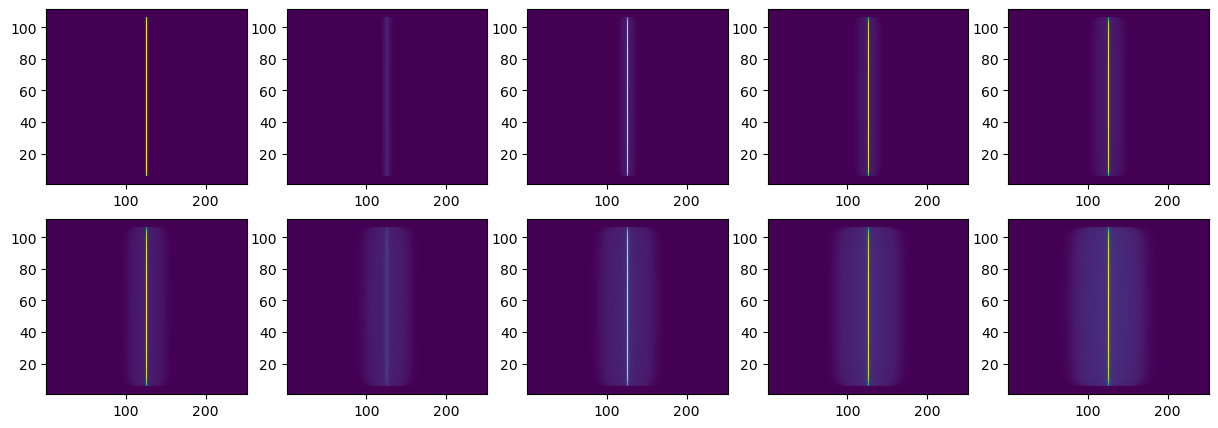

In [18]:
# spatial distribution
import matplotlib.pyplot as plt
xi, yi = np.mgrid[1:252:1,1:112:1]
fig, axes = plt.subplots(ncols=5, nrows=2, figsize = (15,5))
for jj in range(2):
    for kk in range(5):
        axes[jj,kk].pcolormesh(xi, yi, number_rho[(jj*5+kk+1)][0][0].reshape([nx_o[0],ny_o[0],nz_o[0]])[0])
        # axes[jj,kk].contour(xi, yi, data[jj*5+kk].sum(axis=-1)[0,1])

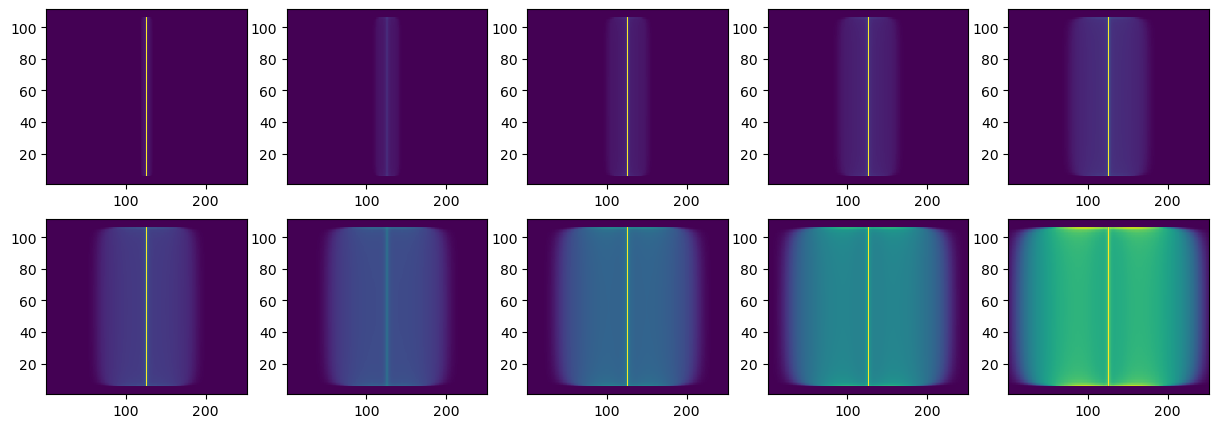

In [12]:
# spatial distribution
import matplotlib.pyplot as plt
xi, yi = np.mgrid[1:252:1,1:112:1]
fig, axes = plt.subplots(ncols=5, nrows=2, figsize = (15,5))
for jj in range(2):
    for kk in range(5):
        axes[jj,kk].pcolormesh(xi, yi, number_rho[(jj*5+kk+1)][0][0].reshape([nx_o[0],ny_o[0],nz_o[0]])[0])
        # axes[jj,kk].contour(xi, yi, data[jj*5+kk].sum(axis=-1)[0,1])

# save data

In [117]:
for ii in [50,80,210]:
    Ey = [EM[i][0][1]*conversion_table_reverse['TO_Volt/m'] for i in range(0,10000,100)]
    Ey = [Ey[i].reshape([nx_o[0],ny_o[0],nz_o[0]])[0,ii,55] for i in range(100)]
    x = np.linspace(0,100,num=100)*dt*conversion_table_reverse['TO_second']*100*10**9
    # data in point pair
    np.savetxt('Ey@'+str(ii)+'.txt',np.transpose(Ey).flatten())
xi, yi = np.mgrid[1:252:1,1:112:1]
for i in range(11):
    # data in point pairs
    num_save = np.transpose([number_rho[i][0][0].reshape([nx_o[0],ny_o[0],nz_o[0]])[0]/conversion_table_reverse['TO_meter']**3])
    np.savetxt('number density@'+str(i)+'.txt',num_save.flatten())

In [118]:
np.array(number_rho[0][0][0]).reshape([nx_o[0],ny_o[0],nz_o[0]])[0].shape

(251, 111)

In [19]:
from numba import jit
@jit
def calculate_p_e(npx,npy,npz,nx_o,ny_o,nz_o,f,p_mesh,e_mesh):
    for ix in range(nx_o):
        for iy in range(ny_o):
            for iz in range(nz_o): 
                for ipx in range(npx):
                    for ipy in range(npy):
                        for ipz in range(npz):
#                             p_mesh[0,ix-120,iy,iz,ipx,ipy,ipz] = (((ipz-npz/2)*dpz[0])**2+((ipy-npy/2)*dpy[0])**2+((ipx-npx/2)*dpx[0])**2)**(1/2)
                            
#                             p_mesh[1,ix-120,iy,iz,ipx,ipy,ipz] = (((ipz-npz/2)*dpz[1])**2+((ipy-npy/2)*dpy[1])**2+((ipx-npx/2)*dpx[1])**2)**(1/2)
                            
                            e_mesh[ix,iy,iz,ipx,ipy,ipz] = ((((ipz-npz/2)*dpz[0])**2+((ipy-npy/2)*dpy[0])**2+((ipx-npx/2)*dpx[0])**2)*c**2 +\
                                                                  masses[0]**2*c**4)**(1/2)
    f[0] = p_mesh
    f[1] = e_mesh
    return f


@jit
def calculate_l(npx,npy,npz,nx_o,ny_o,nz_o,f,par):
    for ix in range(nx_o):
        for iy in range(ny_o):
            for iz in range(nz_o): 
                for ipx in range(npx):
                    for ipy in range(npy):
                        for ipz in range(npz):
                            par[ix,iy,iz,ipx,ipy,ipz] = f[ix,iy,iz,ipx,ipy,ipz]*dx*dy*dz*dpx[0]*dpy[0]*dpz[0]
    return par

In [20]:
import time
p_mesh = np.zeros([nx_o[0], ny_o[0], nz_o[0], npx, npy, npz])
e_mesh = np.zeros([nx_o[0], ny_o[0], nz_o[0], npx, npy, npz])
s = np.zeros([2,nx_o[0], ny_o[0], nz_o[0], npx, npy, npz])

start_time = time.time()
print('start')
s = calculate_p_e(npx,npy,npz,nx_o[0],ny_o[0],nz_o[0], s, p_mesh, e_mesh)
p_mesh = s[0]
e_mesh = s[1]
end_time = time.time()
print((end_time-start_time)/3600,'hours')

start
0.00021607802973853217 hours


In [21]:
import copy,time
x = np.arange(len(dis))
e_total = np.arange(len(dis))
p_total = np.arange(len(dis))
par = np.zeros([nx_o[0], ny_o[0], nz_o[0], npx, npy, npz])
start_time = time.time()
for i in range(len(dis)):
    print(i)
    f = copy.copy(dis[i][0][0][0].reshape([nx_o[0],ny_o[0],nz_o[0],npx,npy,npz]))
    par = calculate_l(npx,npy,npz,nx_o[0],ny_o[0],nz_o[0],f,par)
    e_total[i] = (par*e_mesh).sum()
    p_total[i] = (par*p_mesh).sum()
end_time = time.time()
print((end_time-start_time)/3600,'hours')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
0.00046139657497406005 hours


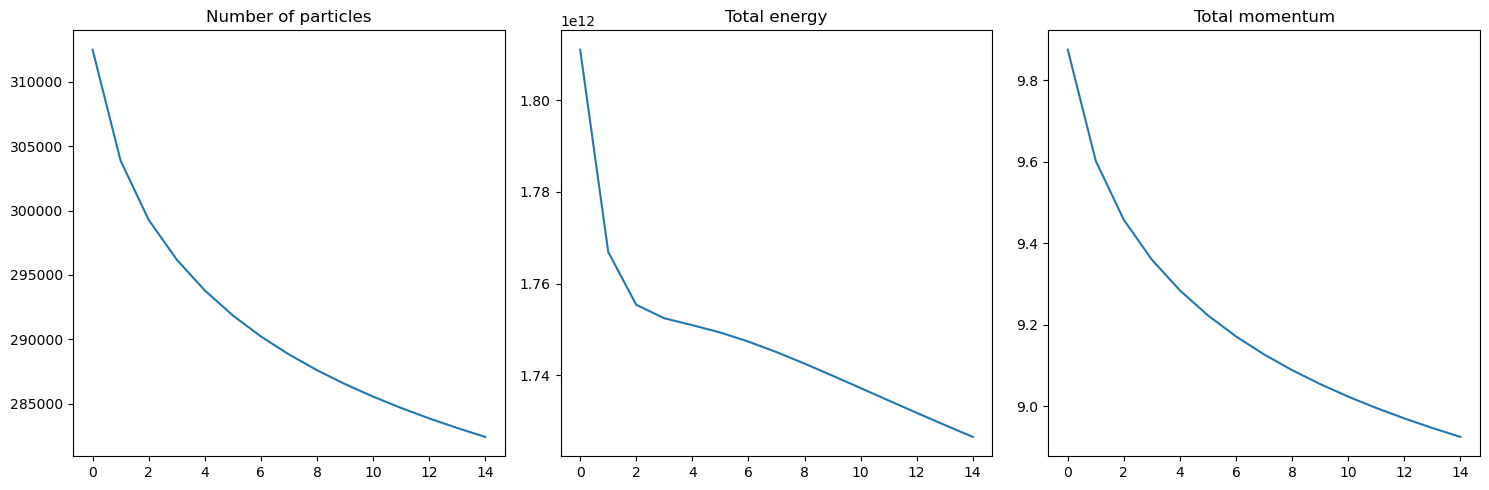

In [22]:
# spatial distribution
import matplotlib.pyplot as plt
# 创建一个图形和四个子图
fig, axs = plt.subplots(1, 3, figsize=(15, 5)) # 2x2子图网格

out = np.zeros(len(dis))
rho = np.zeros(len(dis))
x = range(len(dis))
for i in range(len(dis)):
    out[i] = (dis[i][0][0][0]*dx*dy*dz*dpx[0]*dpy[0]*dpz[0]).sum()
    rho[i] = number_rho[i][0][0][0].reshape([nx_o[0],ny_o[0],nz_o[0]]).sum()

axs[0].plot(x,out)
axs[0].set_title('Number of particles')
axs[1].plot(x,e_total)
axs[1].set_title('Total energy')
axs[2].plot(x,rho)
axs[2].set_title('Total momentum')
# 调整子图间距
plt.tight_layout()

# 显示图形
plt.show()
